In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb


In [2]:
# Load training data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()


Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

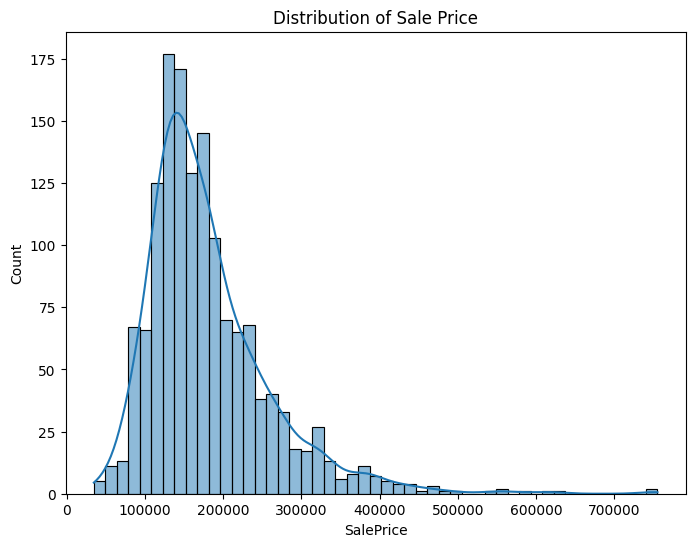

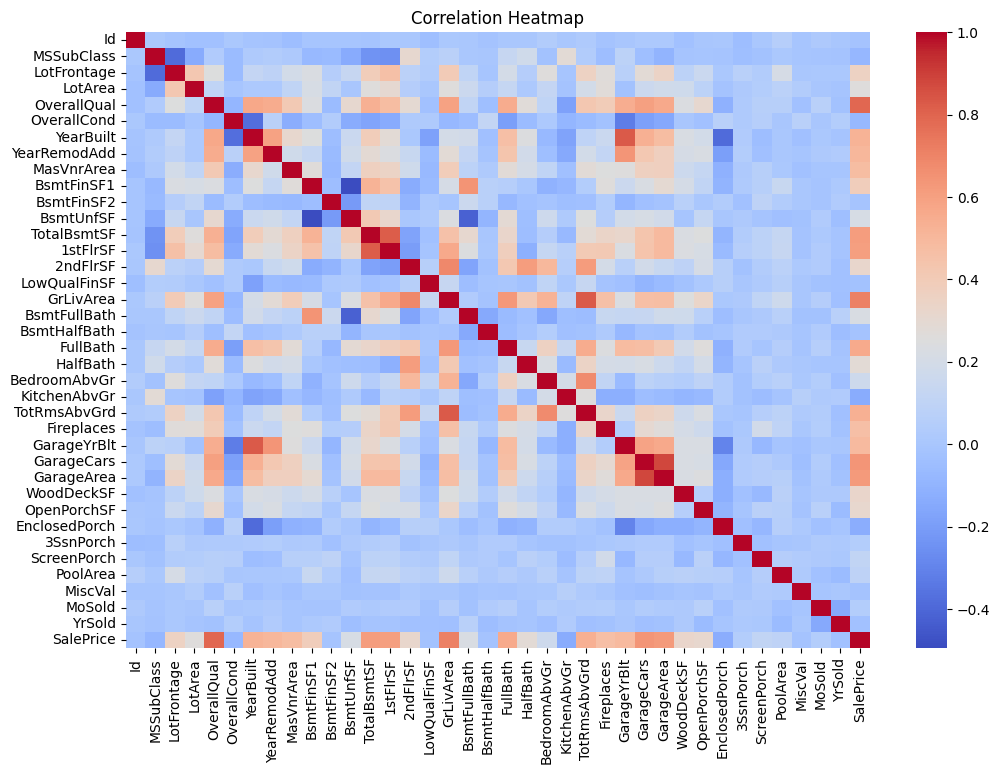

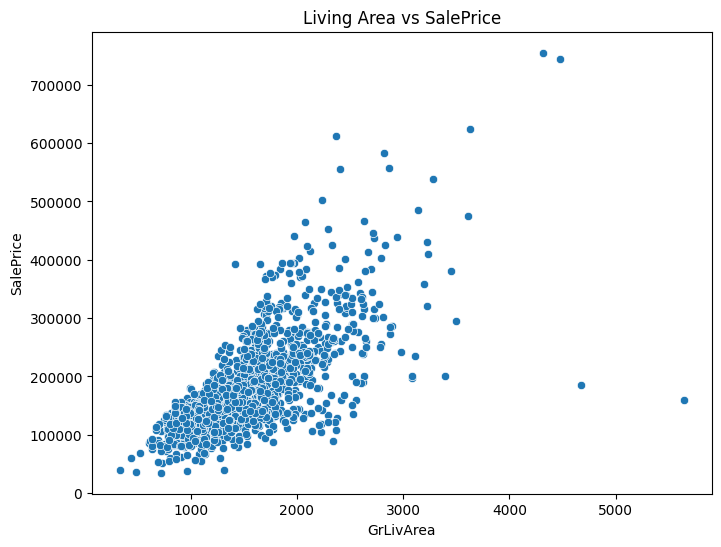

In [3]:
train.info()
train.describe()

# Check missing values
missing = train.isnull().sum().sort_values(ascending=False)
print("Top 20 Missing Values:\n", missing.head(20))

# Distribution of SalePrice
plt.figure(figsize=(8,6))
sns.histplot(train["SalePrice"], kde=True)
plt.title("Distribution of Sale Price")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

# Scatterplot - GrLivArea vs SalePrice
plt.figure(figsize=(8,6))
sns.scatterplot(x=train["GrLivArea"], y=train["SalePrice"])
plt.title("Living Area vs SalePrice")
plt.show()


In [4]:
# Separate features and target
y = train["SalePrice"]
X = train.drop(["SalePrice"], axis=1)

# Combine train & test for consistent encoding
all_data = pd.concat([X, test], axis=0)

# Handle missing values
for col in all_data.select_dtypes(include=[np.number]).columns:
    all_data[col] = all_data[col].fillna(all_data[col].median())

for col in all_data.select_dtypes(include=["object"]).columns:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# One-hot encode categorical columns
all_data = pd.get_dummies(all_data, drop_first=True)

# Split back into train and test
X = all_data.iloc[:train.shape[0], :]
X_test_final = all_data.iloc[train.shape[0]:, :]

# Train/validation split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set (final):", X_test_final.shape)


Training set: (1168, 245)
Validation set: (292, 245)
Test set (final): (1459, 245)


In [5]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_val)

# Compute RMSE manually
mse = mean_squared_error(y_val, lr_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, lr_preds)

print("Linear Regression Results")
print("RMSE:", rmse)
print("R2:", r2)

Linear Regression Results
RMSE: 49048.34018697649
R2: 0.6863575798323693


In [6]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_val)

# Compute RMSE manually
mse = mean_squared_error(y_val, dt_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, dt_preds)

print("Decision Tree Results")
print("RMSE:", rmse)
print("R2:", r2)


Decision Tree Results
RMSE: 43069.91129630891
R2: 0.7581566664878269


In [7]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)

rf_mse = mean_squared_error(y_val, rf_preds)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_val, rf_preds)

print("Random Forest Results")
print("RMSE:", rf_rmse)
print("R2:", rf_r2)


Random Forest Results
RMSE: 28996.040768643164
R2: 0.8903866201323991


In [8]:
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
gb_preds = gb.predict(X_val)

gb_mse = mean_squared_error(y_val, gb_preds)
gb_rmse = np.sqrt(gb_mse)
gb_r2 = r2_score(y_val, gb_preds)

print("Gradient Boosting Results")
print("RMSE:", gb_rmse)
print("R2:", gb_r2)


Gradient Boosting Results
RMSE: 28632.344343034925
R2: 0.8931191294302506


In [9]:
xgbr = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
xgbr.fit(X_train, y_train)
xgb_preds = xgbr.predict(X_val)

xgb_mse = mean_squared_error(y_val, xgb_preds)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_val, xgb_preds)

print("\nXGBoost Results")
print("RMSE:", xgb_rmse)
print("R2:", xgb_r2)



XGBoost Results
RMSE: 26278.566779792236
R2: 0.9099695086479187


In [10]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Score (RMSE):", -grid_search.best_score_)


Best Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Score (RMSE): 29488.848383207824


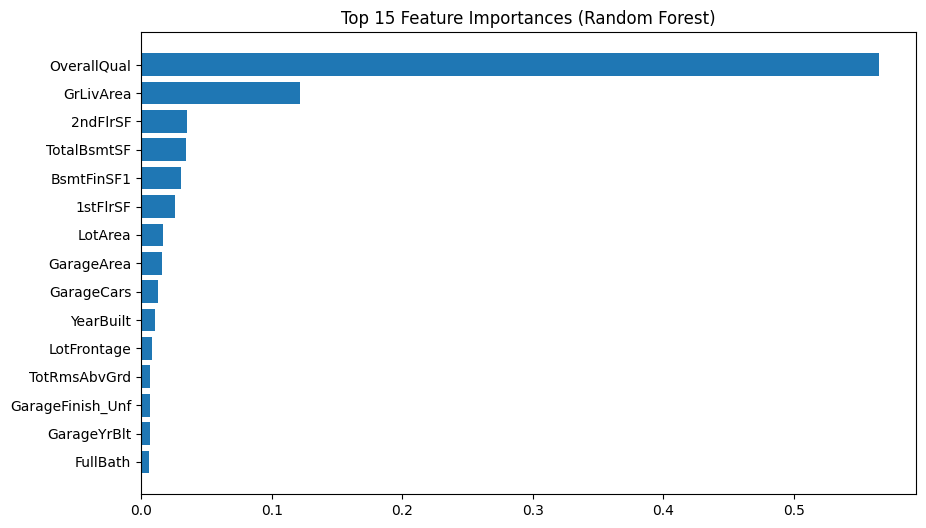

In [11]:
best_rf = grid_search.best_estimator_

importances = best_rf.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


In [13]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_val, lr_preds)),
        np.sqrt(mean_squared_error(y_val, dt_preds)),
        np.sqrt(mean_squared_error(y_val, rf_preds)),
        np.sqrt(mean_squared_error(y_val, gb_preds)),
        np.sqrt(mean_squared_error(y_val, xgb_preds))
    ],
    "R2 Score": [
        r2_score(y_val, lr_preds),
        r2_score(y_val, dt_preds),
        r2_score(y_val, rf_preds),
        r2_score(y_val, gb_preds),
        r2_score(y_val, xgb_preds)
    ]
})

results.sort_values(by="RMSE")



,Model,RMSE,R2 Score
4,XGBoost,26278.566780,0.909970
3,Gradient Boosting,28632.344343,0.893119
2,Random Forest,28996.040769,0.890387
1,Decision Tree,43069.911296,0.758157
0,Linear Regression,49048.340187,0.686358
